In [1]:
%matplotlib inline
import os.path as op
from collections import Counter
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
from nilearn import masking

In [2]:
IN_DIR = "/home/data/nbc/misc-projects/Salo_PowerReplication"
DATASETS = ["dset-cambridge", "dset-camcan", "dset-cohen", "dset-dalenberg", "dset-dupre"]
if not op.isfile("dseg_value_counts.tsv"):
    df = None
    for dset in DATASETS:
        dset_dir = op.join(IN_DIR, dset)
        deriv_dir = op.join(dset_dir, "derivatives/power")
        subjects = sorted(glob(op.join(deriv_dir, "sub-*")))
        subjects = [op.basename(sub) for sub in subjects]
        for sub in subjects:
            dseg_file = op.join(
                deriv_dir,
                sub,
                "anat",
                f"{sub}_space-scanner_res-bold_desc-totalMaskWithCSF_dseg.nii.gz",
            )
            mask_file = op.join(
                deriv_dir,
                sub,
                "anat",
                f"{sub}_space-scanner_res-bold_desc-totalMaskWithCSF_mask.nii.gz",
            )
            data = masking.apply_mask(dseg_file, mask_file)
            value_counts = Counter(data)
            row = pd.Series(value_counts)
            row["subject"] = sub
            row["dataset"] = dset
            if df is None:
                df = row.to_frame().T
            else:
                df = df.append(row, ignore_index=True)

    df = df.rename(
        columns={
            1.0: "Cortical Ribbon",
            2.0: "Subcortical Nuclei",
            3.0: "Cerebellum",
            4.0: "Superficial WM",
            5.0: "Deeper WM",
            6.0: "Deepest WM",
            7.0: "Superficial CSF",
            8.0: "Deeper CSF",
        }
    )
    df["Total"] = df[[
        "Cortical Ribbon",
        "Subcortical Nuclei",
        "Cerebellum",
        "Superficial WM",
        "Deeper WM",
        "Deepest WM",
        "Superficial CSF",
        "Deeper CSF",
    ]].sum(axis=1)

    df = df[[
        "dataset",
        "subject",
        "Cortical Ribbon",
        "Subcortical Nuclei",
        "Cerebellum",
        "Superficial WM",
        "Deeper WM",
        "Deepest WM",
        "Superficial CSF",
        "Deeper CSF",
        "Total"
    ]]
    df.to_csv("dseg_value_counts.tsv", sep="\t", line_terminator="\n", index=False)

In [33]:
df["Total"] = df[[
    "Cortical Ribbon",
    "Subcortical Nuclei",
    "Cerebellum",
    "Superficial WM",
    "Deeper WM",
    "Deepest WM",
    "Superficial CSF",
    "Deeper CSF",
]].sum(axis=1)

df = df[[
    "dataset",
    "subject",
    "Cortical Ribbon",
    "Subcortical Nuclei",
    "Cerebellum",
    "Superficial WM",
    "Deeper WM",
    "Deepest WM",
    "Superficial CSF",
    "Deeper CSF",
    "Total"
]]

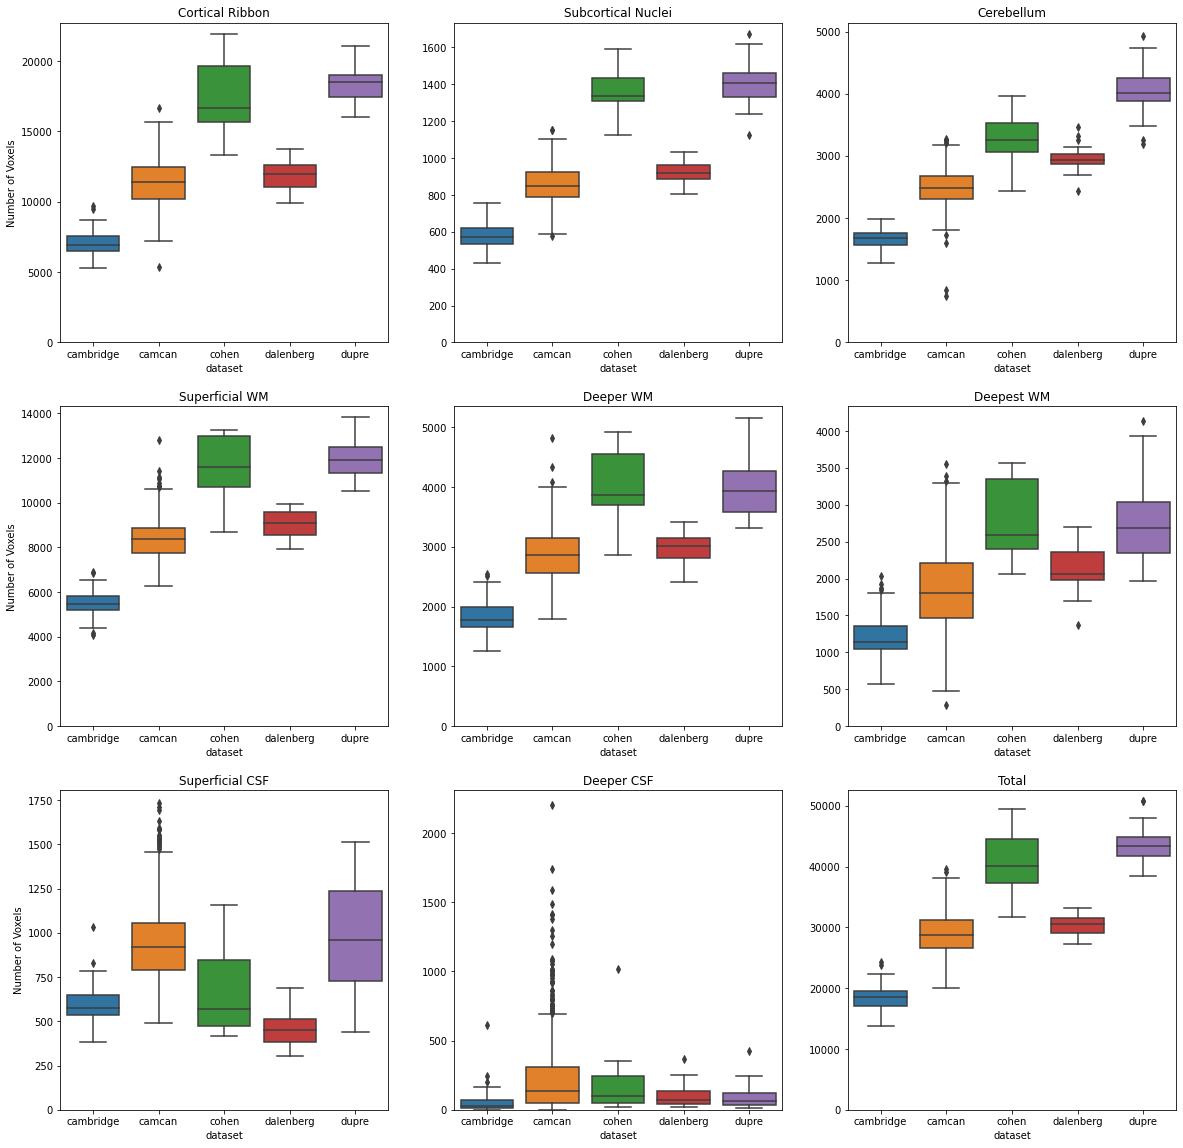

In [35]:
import seaborn as sns
data_cols = [c for c in df.columns if c != c.lower()]
fig, axes = plt.subplots(figsize=(20, 20), nrows=3, ncols=3)

df["dataset"] = df["dataset"].str.replace("dset-", "")

c = 0
for i_row in range(len(axes)):
    for j_col in range(len(axes[i_row])):
        ax = axes[i_row, j_col]
        if c >= len(data_cols):
            ax.axis("off")
            continue
        
        data_col = data_cols[c]
        c += 1
        data_df = df[["dataset", "subject", data_col]]
        ax = sns.boxplot(data=data_df, x="dataset", y=data_col, ax=ax)
        ax.set_ylabel("")
        ax.set_ylim((0, None))
        ax.set_title(data_col)
        if j_col == 0:
            ax.set_ylabel("Number of Voxels")

fig.savefig("../figures/segmentation_voxel_counts.svg")